# Setup

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
# from tensorflow.keras import layers
import numpy as np
from numpy.random import default_rng
import scipy.linalg as la
from scipy.special import gammaln
import scipy.cluster.vq as vq
import matplotlib.pyplot as plt
import netCDF4 as nc
import re
import pandas as pd
import sklearn as skl
import seaborn as sns
from tqdm.auto import tqdm
import tuning_fun as tu
import emulator_fun as ef
import time

2025-06-18 01:49:01.006014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750211341.019775 1563008 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750211341.023875 1563008 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750211341.035222 1563008 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750211341.035233 1563008 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750211341.035235 1563008 computation_placer.cc:177] computation placer alr

In [2]:
# allocating GPU memory

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# model

## read files

In [37]:
case_name = 'updraft_coal_4ma_r2_N10000_dt300'
base_path = 'summary_ncs/'
# base_path = '/Users/arthurhu/github/BOSS_PPE/summary_ncs/'
# base_path = '/pscratch/sd/a/arthurhu/BOSS_PPE/summary_ncs/'
filename = case_name + '.nc'

param_all_idx = np.arange(36)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
param_interest_idx = np.arange(16,26)
# param_interest_idx = np.arange(28,39)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))
param_not_int_idx = [i for i in param_all_idx if i not in param_interest_idx]

param_train = ef.get_params(base_path, filename, param_interest_idx)

nppe, npar = param_train['vals'].shape

n_input = param_train['vals'].shape[1]


In [38]:
model_name = 'multioutput_updraft_coal_4ma_r2'
cc_model = tf.keras.models.load_model('models/' + model_name + '.keras', compile=False)

orig_param_csv = '/global/u2/a/arthurhu/Cloud_BOSS/param_consolid_simPL'
param_table = pd.read_csv(orig_param_csv + '.csv')
param_names = param_table.columns[1+param_interest_idx].to_list()

param_mean = param_table.values[0, 1+param_interest_idx].astype(np.float32)
param_std = param_table.values[1, 1+param_interest_idx].astype(np.float32)
nparam = len(param_names)

param_mean, param_names

(array([-9.0893112e+01,  1.0383171e+00,  2.2136028e+00,  5.4274213e-01,
         1.3385471e+00,  2.1998904e+00, -4.1407935e-02,  5.9687722e-01,
         1.4921914e+00, -1.1678169e+01], dtype=float32),
 ['a0coal_db',
  'bblarge',
  'bbsmall',
  'bx0coal',
  'bxxcoal',
  'bxycoal',
  'by0coal',
  'byxcoal',
  'byycoal',
  'mtrans_db'])

In [39]:
dataset = nc.Dataset(base_path + filename, mode='r')
n_init = getattr(dataset, 'n_init')
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [40]:
n_tgt_ics = tgt_raw_vals[0].shape[0]
npar = n_input - n_init
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)

In [41]:
init_vars = getattr(dataset, 'init_var')
if isinstance(init_vars, str):
    init_vars = [init_vars]

initvar_matrix = []

for i_init, init_var in enumerate(init_vars):
    initvar_matrix.append(np.expand_dims(dataset.variables['case_' + init_var][:], axis=1))

tgt_sim_ics = np.concatenate(initvar_matrix, axis=1)
ncases = tgt_raw_vals[0].shape[0]
nvar = len(var_constraints)

In [42]:
from sklearn import preprocessing

ppe_var_presence = []
ppe_norm = []
ppe_data = []
tgt_var_presence = []
tgt_norm = []
tgt_data = []
standard_scales = []
minmaxscales = []

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

dmin = 0.
dmax = 9.2
drange = dmax - dmin


for idx, eff0 in enumerate(eff0s):
    if ppe_raw_vals[idx].ndim >= 2:
        ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
        tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
    else:
        ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
        tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)

    ppe_var_presence.append(ppe_raw_val_reshaped > eff0/100)
    tgt_var_presence.append(tgt_raw_val_reshaped > eff0/100)

    if 'V_M' in var_constraints[idx]:
        mmscale = preprocessing.MinMaxScaler().fit(ppe_raw_val_reshaped)
        # manually set all minmaxscale to the same range
        mmscale.data_min_[:] = dmin
        mmscale.data_max_[:] = dmax
        mmscale.data_range_[:] = drange
        mmscale.scale_[:] = 1/drange
        minmaxscales.append(mmscale)
        ppe_data.append(mmscale.transform(ppe_raw_val_reshaped))
        tgt_data.append(mmscale.transform(tgt_raw_val_reshaped))
    else:
        ppe_norm.append(ef.smooth_linlog(ppe_raw_val_reshaped, eff0))
        tgt_norm.append(ef.smooth_linlog(tgt_raw_val_reshaped, eff0))    
        standscale = preprocessing.StandardScaler().fit(ppe_norm[-1])
        standard_scales.append(standscale)

        

mom_consistency_mask = np.min(np.array(ppe_var_presence), axis=0)
scale_mask = np.max(mom_consistency_mask, axis=0)

for i, iscale in enumerate(standard_scales):
    iscale.scale_ = iscale.scale_ * scale_mask
    dat = iscale.transform(ppe_norm[i])
    dat[np.isinf(dat)] = np.nan
    ppe_data.append(dat)
    dat = iscale.transform(tgt_norm[i])
    dat[np.isinf(dat)] = np.nan
    tgt_data.append(dat)

/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1085: RuntimeWarning: divide by zero encountered in divide
  X /= self.scale_
/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1085: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1085: RuntimeWarning: divide by zero encountered in divide
  X /= self.scale_
/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1085: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1085: RuntimeWarning: divide by zero encountered in divide
  X /= self.scale_
/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn

In [43]:
# from sklearn import preprocessing

# dmin = 0.
# dmax = 9.2
# drange = dmax - dmin

# minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
# x_all = minmaxscale.transform(param_train['vals'])

# ppe_var_presence = []
# ppe_data = []
# tgt_var_presence = []
# tgt_data = []
# standard_scales = []
# minmaxscales = []

# idx = 0
# eff0 = eff0s[idx]
# for idx, eff0 in enumerate(eff0s):
#     if ppe_raw_vals[idx].ndim >= 2:
#         ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
#         tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
#     else:
#         ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
#         tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)

#     ppe_var_presence.append(ppe_raw_val_reshaped > eff0/100)
#     tgt_var_presence.append(tgt_raw_val_reshaped > eff0/100)

#     # ppe_norm = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
#     # tgt_norm = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
#     # standscale = preprocessing.StandardScaler().fit(ppe_norm)
#     # standard_scales.append(standscale)
#     # ppe_data.append(standscale.transform(ppe_raw_val_reshaped))
#     # tgt_data.append(standscale.transform(tgt_raw_val_reshaped))
#     # TODO: set all mins to 0 and all maxes to 9.1
#     mmscale = preprocessing.MinMaxScaler().fit(ppe_raw_val_reshaped)
#     # manually set all minmaxscale to the same range
#     mmscale.data_min_[:] = dmin
#     mmscale.data_max_[:] = dmax
#     mmscale.data_range_[:] = drange
#     mmscale.scale_[:] = 1/drange
#     minmaxscales.append(mmscale)
#     ppe_data.append(mmscale.transform(ppe_raw_val_reshaped))
#     tgt_data.append(mmscale.transform(tgt_raw_val_reshaped))

In [44]:
import sklearn.model_selection as mod_sec
y_train_wpresence = []
y_train_rawv = []
y_val_wpresence = []
y_val_rawv = []

x_train, x_val, _, _ = mod_sec.train_test_split(x_all, ppe_var_presence[0], test_size=0.2, random_state=1)

for ivar, (ppe_varp, ppe_varr) in enumerate(zip(ppe_var_presence, ppe_data)):
    _, _, y_train_wpresence_single, y_val_wpresence_single = mod_sec.train_test_split(x_all, ppe_varp, test_size=0.2, random_state=1)
    _, _, y_train_rawv_single, y_val_rawv_single = mod_sec.train_test_split(x_all, ppe_varr, test_size=0.2, random_state=1)
    y_train_wpresence.append(y_train_wpresence_single)
    y_train_rawv.append(np.nan_to_num(y_train_rawv_single, nan=-1001, neginf=-1001, posinf=-1001))
    y_val_wpresence.append(y_val_wpresence_single)
    y_val_rawv.append(np.nan_to_num(y_val_rawv_single, nan=-1001, neginf=-1001, posinf=-1001))


In [45]:
[i.shape for i in ppe_data], [i.shape for i in tgt_data]

([(10000, 720), (10000, 720), (10000, 720)],
 [(144, 720), (144, 720), (144, 720)])

(array([3.0000e+00, 1.8000e+01, 6.0000e+01, 4.6000e+01, 9.1000e+01,
        1.1400e+02, 4.4600e+02, 4.9300e+02, 1.0940e+03, 6.0310e+03,
        9.8910e+03, 1.2846e+04, 1.8855e+04, 1.6465e+04, 3.7360e+03,
        1.6010e+03, 1.5080e+03, 1.2100e+03, 1.0280e+03, 8.8700e+02,
        9.7300e+02, 8.9100e+02, 7.5400e+02, 5.4000e+02, 4.6800e+02,
        3.8400e+02, 3.6400e+02, 3.5000e+02, 2.6000e+02, 2.9200e+02,
        3.2900e+02, 3.8800e+02, 3.8800e+02, 3.2600e+02, 2.6800e+02,
        2.3200e+02, 1.3900e+02, 9.7000e+01, 1.2100e+02, 9.8000e+01,
        7.7000e+01, 6.9000e+01, 5.7000e+01, 5.8000e+01, 5.4000e+01,
        5.0000e+01, 3.5000e+01, 3.0000e+01, 2.5000e+01, 2.0000e+01,
        2.9000e+01, 2.1000e+01, 2.5000e+01, 1.9000e+01, 1.7000e+01,
        2.2000e+01, 1.4000e+01, 1.1000e+01, 2.0000e+01, 1.6000e+01,
        1.4000e+01, 1.5000e+01, 1.3000e+01, 7.0000e+00, 1.2000e+01,
        1.2000e+01, 1.0000e+01, 1.5000e+01, 1.0000e+01, 7.0000e+00,
        1.2000e+01, 8.0000e+00, 5.0000e+00, 1.00

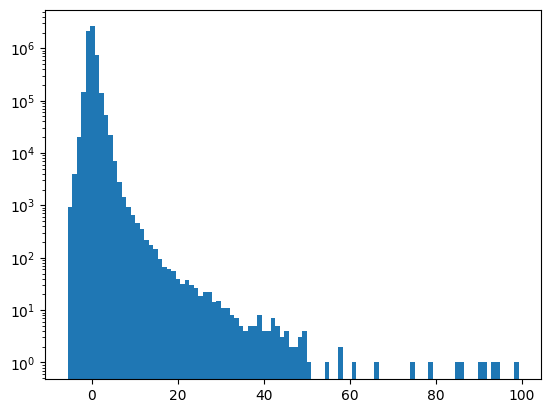

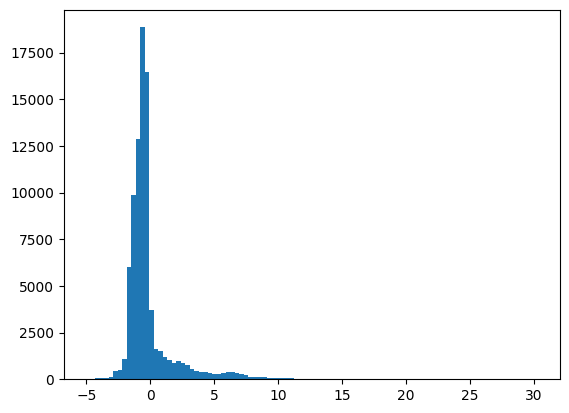

In [46]:
i = 0

plt.hist(ppe_data[i].flatten(), bins=100)
plt.yscale('log')
plt.figure()
plt.hist(tgt_data[i].flatten(), bins=100)

## run

In [47]:
n_tgt_ics

144

In [48]:
tfd = tfp.distributions
tfb = tfp.bijectors

nchains = 8
# tf.keras.backend.set_floatx('float32')
IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = minmaxscale.transform(IC_with_dummy)[:,:n_init].astype('float32')
# valid_mask = tf.math.is_finite(tgt_data)
weights = np.ones([n_tgt_ics, nobs]).astype('float32')


In [49]:
params = tf.zeros(npar) + 0.5
params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
param_lp = tf.reduce_sum(tfd.Uniform(low=0.0,
                                     high=1.0).log_prob(params_2d))
input_norm = tf.concat([IC_norm, params_2d], axis=1) # n_tgt_ics x n_input
y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs
obs_lps = []

# for tgt_sngl, emu_sngl in zip(tgt_data, y_emu):
#     valid_mask = tf.math.is_finite(tgt_sngl)
#     tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
#     emu_valid = tf.boolean_mask(emu_sngl, valid_mask)
#     obs_lps.append(tf.reduce_mean(tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=1.).log_prob(tf.cast(emu_valid, tf.float32))))

for tgt_sngl, pres_sngl, water_sngl in zip(tgt_data, y_emu['presence'], y_emu['water']):
    valid_mask = tf.math.is_finite(tgt_sngl)
    tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
    pres_sngl = pres_sngl.numpy()
    pres_sngl[pres_sngl<0.1] = 0.
    emu_valid = tf.boolean_mask(pres_sngl * water_sngl, valid_mask)
    obs_lps.append(tf.reduce_mean(tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=1.).log_prob(tf.cast(emu_valid, tf.float32))))

# eps = 1e-7
# y_emu_wpresence = tf.cast(y_emu[0], tf.float32)
# y_emu_wpresence_clipped = tf.clip_by_value(y_emu_wpresence, eps, 1 - eps) # to avoid NaN in log likelihood
# # valid_mask_float = tf.cast(valid_mask, tf.float32)
# wpresence_lps = tfp.distributions.Bernoulli(probs=y_emu_wpresence_clipped).log_prob(valid_mask_float)
# wpresence_lp = tf.reduce_sum(wpresence_lps)

print(tf.reduce_sum(obs_lps))

tf.Tensor(-5.9364977, shape=(), dtype=float32)


In [50]:
param_lps = []
sigma_lps = []
obs_lps = []
# wpresence_lps = []
exp_rate = 1
# sigmas = []
obs_lps = []

for i in tqdm(range(1000)):
    initial_state = tf.random.normal([npar+1])
    # initial_state = tf.concat([
    # tf.random.normal([npar]),
    # tf.random.normal([1],)], axis=-1)

    # initial_state = tf.zeros(npar, dtype='float32')
    params = initial_state[:-1]
    params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
    theta=tfb.Sigmoid().forward(params_2d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta))

    log_sigma = initial_state[-1]
    sigma = tf.exp(log_sigma)
    # sigma_lp = tfd.Uniform(low=0.1, high=5).log_prob(sigma)
    sigma_lp = tfd.Exponential(rate=exp_rate).log_prob(sigma) + log_sigma

    input_norm = tf.concat([IC_norm, theta], axis=1) # n_tgt_ics x n_input
    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs

    obs_lp = []

    # for tgt_sngl, emu_sngl in zip(tgt_data, y_emu):
    #     valid_mask = tf.math.is_finite(tgt_sngl)
    #     tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
    #     emu_valid = tf.boolean_mask(emu_sngl, valid_mask)
    
    for tgt_sngl, pres_sngl, water_sngl in zip(tgt_data, y_emu['presence'], y_emu['water']):
        valid_mask = tf.math.is_finite(tgt_sngl)
        tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
        pres_sngl = pres_sngl.numpy()
        pres_sngl[pres_sngl<0.1] = 0.
        emu_valid = tf.boolean_mask(pres_sngl * water_sngl, valid_mask)
        obs_lp.append(tf.reduce_mean(tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=sigma).log_prob(tf.cast(emu_valid, tf.float32))))
    # for tgt_sngl, emu_sngl in zip(tgt_data, y_emu):
    #     valid_mask = tf.math.is_finite(tgt_sngl)
    #     tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
    #     emu_valid = tf.boolean_mask(emu_sngl, valid_mask)
    #     obs_lp.append(tf.reduce_mean(tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=sigma).log_prob(tf.cast(emu_valid, tf.float32))))
    param_lps.append(param_lp)
    obs_lps.append(tf.reduce_sum(obs_lp))
    # wpresence_lps.append(wpresence_lp)
    sigma_lps.append(sigma_lp)
    # sigmas.append(sigma)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [51]:
s_obs = np.std(param_lps)/np.std(obs_lps)
m_obs = np.mean(param_lps)/np.mean(obs_lps)
# s_wpr = np.std(param_lps)/np.std(wpresence_lps)
# s_sig = np.std(param_lps)/np.std(sigma_lps)
m_sig = np.mean(param_lps)/np.mean(sigma_lps)
print(m_obs, m_sig, np.mean(param_lps), np.mean(obs_lps), np.mean(sigma_lps))
# obs_lps[:4]

82.94109 1397.2996 -2320.7776 -27.981035 -1.6609019


In [52]:
exp_rate = 1

def get_BOSSemu_lp(params_sigma):
    params = params_sigma[:-1]
    params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
    theta=tfb.Sigmoid().forward(params_2d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta))

    # set up sigma
    log_sigma = params_sigma[-1]
    sigma = tf.exp(log_sigma)
    # sig_lp = tfd.Uniform(low=0.1, high=5).log_prob(sigma)
    sig_lp = tfd.Exponential(rate=exp_rate).log_prob(sigma) + log_sigma

    # get normalized ICs
    input_norm = tf.concat([IC_norm, theta], axis=1) # n_tgt_ics x n_input
    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs

    obs_lps = []
    # for tgt_sngl, emu_sngl in zip(tgt_data, y_emu):
    #     valid_mask = tf.math.is_finite(tgt_sngl)
    #     tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
    #     emu_valid = tf.boolean_mask(emu_sngl, valid_mask)
    for tgt_sngl, pres_sngl, water_sngl in zip(tgt_data, y_emu['presence'], y_emu['water']):
        valid_mask = tf.math.is_finite(tgt_sngl)
        tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
        emu_valid = tf.boolean_mask(pres_sngl * water_sngl, valid_mask)
        obs_lps.append(tf.reduce_mean(tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=sigma).log_prob(tf.cast(emu_valid, tf.float32))))
    # for tgt_sngl, emu_sngl in zip(tgt_data, y_emu):
    #     valid_mask = tf.math.is_finite(tgt_sngl)
    #     tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
    #     emu_valid = tf.boolean_mask(emu_sngl, valid_mask)
    #     obs_lps.append(tf.reduce_mean(tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=sigma).log_prob(tf.cast(emu_valid, tf.float32))))
    obs_lp = tf.reduce_sum(obs_lps)
    return param_lp + m_obs * obs_lp + m_sig * sig_lp

batched_BOSSemu_lp = lambda params_batch: tf.vectorized_map(
get_BOSSemu_lp, params_batch)

num_burnin_steps = 10000
num_samples = 20000
initial_state = tf.random.normal([nchains, npar+1], seed=1)
# initial_state = tf.concat([tf.random.normal([nchains, npar], seed=0),
#                            tf.zeros([nchains, 1])], axis=1)

stepsize = 0.01

hmc = tfp.mcmc.HamiltonianMonteCarlo(batched_BOSSemu_lp, step_size=stepsize, num_leapfrog_steps=3)
adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=hmc,
    num_adaptation_steps=int(num_burnin_steps * 0.8))

start = time.time()

@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(num_results=num_samples,
        current_state=initial_state,   # or your initial_state
        kernel=adaptive_hmc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, kr: kr.inner_results.is_accepted,
        seed=0)

samples, accs = run_chain()

end = time.time()
print(end-start)

189.62253761291504


acceptance rate: [0.78325 0.78435 0.783   0.78415 0.78565 0.7859  0.78575 0.78885]


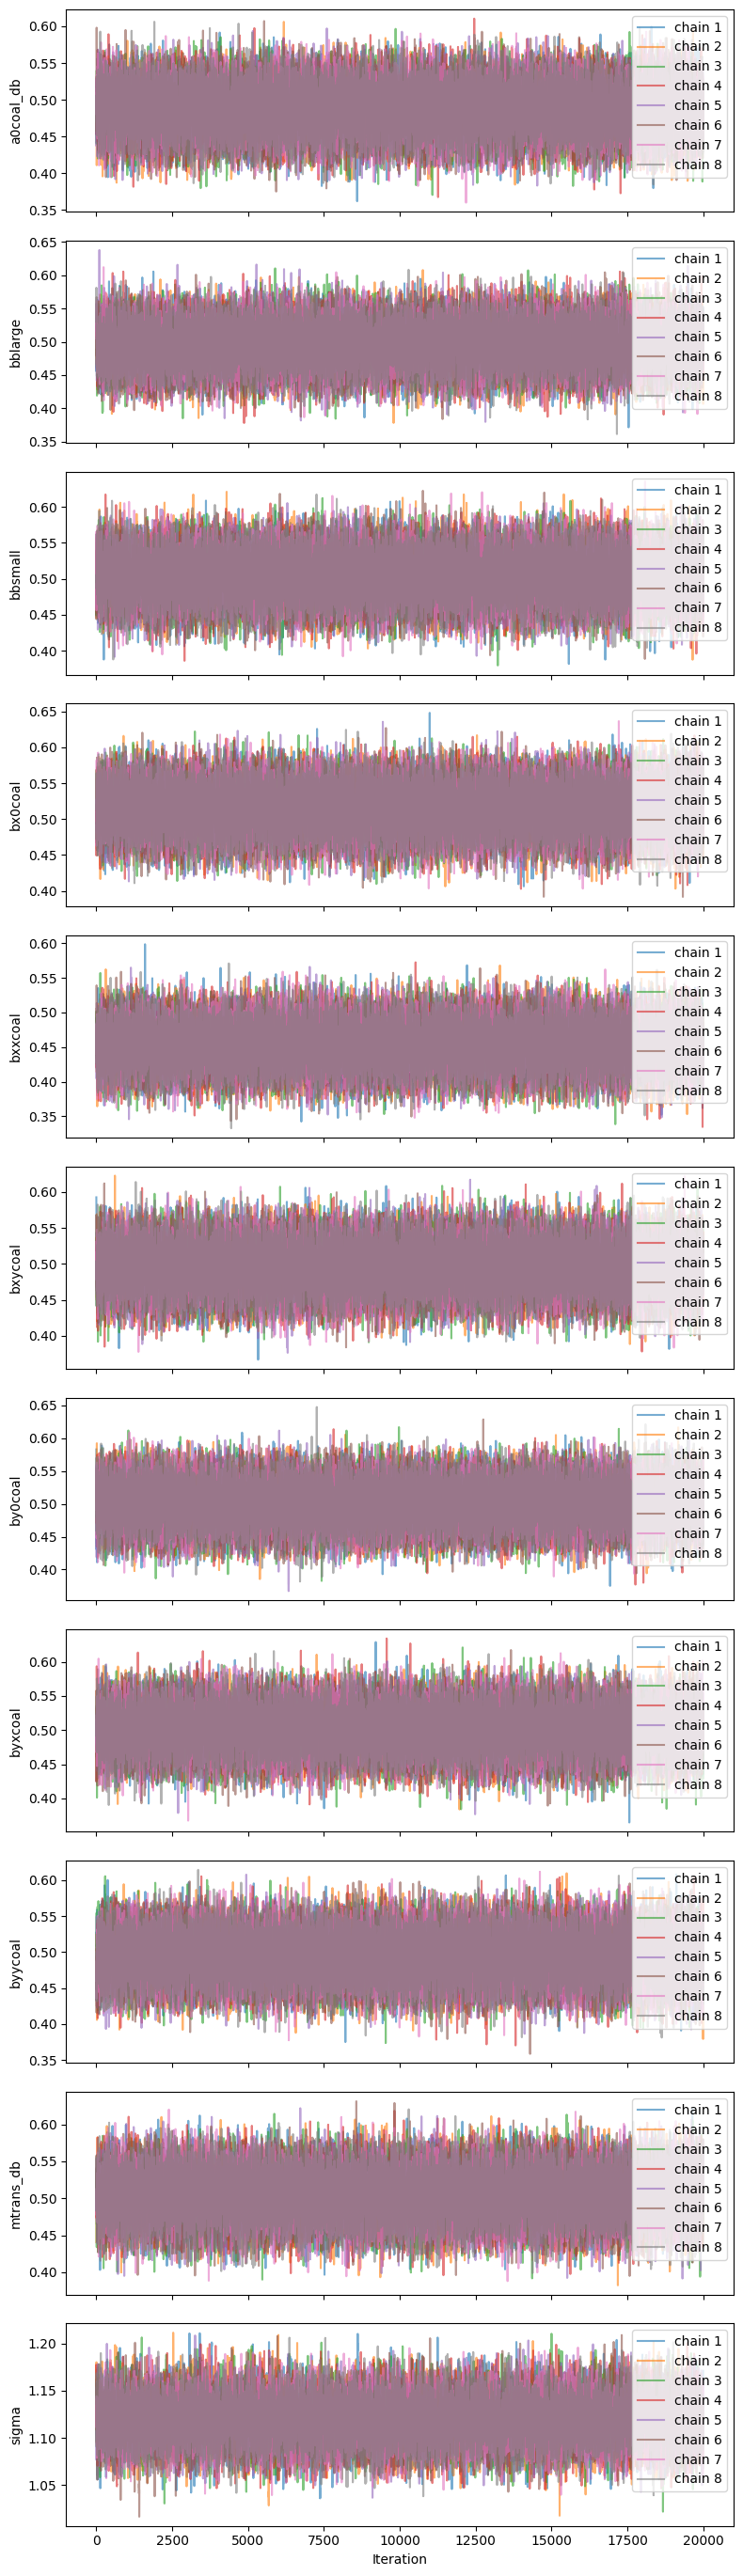

In [53]:
# --- 4. Trace plots ---
def plot_traces(posterior, pnames):
    its, chains, dims = posterior.shape
    fig, axes = plt.subplots(dims, 1, figsize=(8, 2.5*dims), sharex=True)
    for d in range(dims):
        for c in range(chains):
            axes[d].plot(posterior[:,c,d], alpha=0.6, label=f'chain {c+1}')
        axes[d].set_ylabel(pnames[d])
        axes[d].legend(loc='upper right')
    axes[-1].set_xlabel('Iteration')
    plt.tight_layout()
    plt.show()

print("acceptance rate:", sum(accs.numpy())/num_samples)

# try:
#     print("acceptance rate:", sum(kr.is_accepted.numpy())/num_samples)
# except AttributeError:
#     print("acceptance rate:", sum(kr.inner_results.is_accepted.numpy())/num_samples)

param_names_incl_sigma = param_names + ['sigma']
transformed_samples = tf.concat([tfb.Sigmoid().forward(samples[:,:,:-1]), tf.exp(samples[:,:,-1:])], axis=2)
plot_traces(transformed_samples, param_names_incl_sigma)
# transformed_samples = tfb.Sigmoid().forward(samples)
# plot_traces(transformed_samples, param_names)
# kr

In [54]:
# i=7
print(tfp.mcmc.effective_sample_size(samples).numpy())
print(tfp.mcmc.potential_scale_reduction(samples).numpy())
# print(test_run_kernel[i], test_run_step_sizes[i], test_run_time[i])

[[3715.0984 3735.566  3848.7004 4207.796  3926.477  3919.5667 3787.681
  4122.5293 4067.0166 3939.3274 2120.239 ]
 [4012.852  4113.904  3829.037  4099.2407 4033.1687 3575.4827 3706.6006
  3845.9312 3958.702  3779.8086 2257.3672]
 [2995.891  3798.259  3780.1516 3688.726  4141.762  4043.349  3938.5095
  3952.055  3892.0535 3840.2769 2315.1135]
 [3559.7493 3592.1394 3786.098  3921.2073 3761.7017 3809.6052 3773.9631
  4062.9692 3563.3613 3896.991  2395.077 ]
 [4019.9634 3937.9375 4006.9216 4273.1333 3909.1343 3934.3716 3514.6472
  4170.9966 3949.0386 3565.6758 2393.0518]
 [3477.2493 3461.5676 3855.832  3608.7793 3463.939  4003.1719 4027.7268
  3687.2815 3634.4797 3636.7236 2306.1091]
 [3470.8882 3906.9775 3754.8    4009.4365 3912.8708 3696.3733 3995.9673
  3892.809  3973.871  3385.637  2393.3398]
 [3892.484  3875.7864 4015.2146 4014.6235 4078.1687 4032.7896 3934.17
  3888.5083 3990.8455 3795.1936 1713.5579]]
[1.0003033  1.0002462  1.0000145  1.0001808  1.0002127  1.0001378
 1.0004797  1.00

## postprocessing

In [55]:
IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
IC_col3d = tf.tile(IC_col[:, None, :], [1, nchains, 1])
# w_col3d = tf.tile(w_col[:, None, :], [1, nchains, 1])
samples_with_ic = tf.concat([IC_col3d, transformed_samples[:,:,:-1]], axis=2)


In [56]:
samples_with_ic_raw_vals = np.zeros(samples_with_ic.shape, dtype=np.float32)
for ichain in range(nchains):
    samples_with_ic_raw_vals[:, ichain, :] = minmaxscale.inverse_transform(samples_with_ic[:, ichain, :])

samples_raw_vals = samples_with_ic_raw_vals[:,:,n_init:]

In [57]:
np.mean(samples_with_ic[:,:,n_init:].numpy().reshape(num_samples*nchains,nparam), axis=0)
# samples_with_ic[:,:,n_init:].shape

array([0.4876058 , 0.4959284 , 0.5037347 , 0.51490426, 0.4536471 ,
       0.4958814 , 0.5009315 , 0.501691  , 0.49453986, 0.5038228 ],
      dtype=float32)

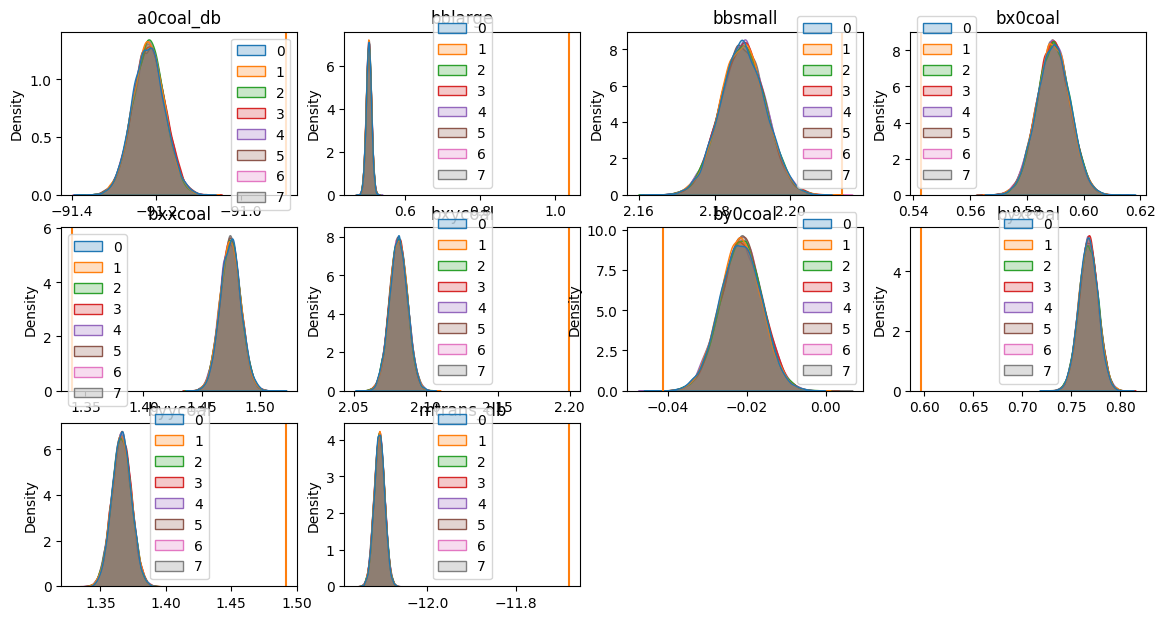

In [58]:
import matplotlib.gridspec as gridspec

# samples_origval = np.concatenate((samples_raw_vals, transformed_samples[:,:,-1:]), axis=2)
samples_origval = samples_raw_vals
# samples_origval = samples_with_ic[:,:,n_init:]

fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for ipost in range(samples_origval.shape[-1]):
# for iparam, param_name in enumerate(param_names):
    param_name = param_names[ipost]
    ax = fig.add_subplot(gs[ipost])
    sns.kdeplot(samples_origval[:,:,ipost], fill=True)
    plt.axvline(param_mean[ipost], color='tab:orange')
    plt.title(param_name)
    # plt.plot((param_mean[iparam], param_mean[iparam]), ax.get_ylim(), color='tab:red')

plt.show()


In [59]:
# # sample_sum_chains = samples_origval.reshape(num_samples*nchains,nparam)
# sample_df = pd.DataFrame(samples_origval[:,0,:], columns=param_names)
# sns.pairplot(sample_df, kind="kde")

# validation

In [60]:
tsamples_combine_chains = transformed_samples[:,:,:-1].numpy().reshape(num_samples*nchains, npar)
meanresult = np.mean(tsamples_combine_chains, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [IC_norm.shape[0], 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)
vars_after_MCMC_norm = cc_model(meanresults_incl_ics)


In [61]:
y_pred_inv = []
y_true_inv = []
y_pred = []
y_true = []

# for i in range(nvar):
#     y_pred_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(cc_model(meanresults_incl_ics)[i].numpy().astype('float64')), eff0s[i]))
#     y_true_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(tgt_data[i].astype('float64')), eff0s[i]))
#     y_pred.append(cc_model(meanresults_incl_ics)[i].numpy().astype('float64'))
#     y_true.append(tgt_data[i].astype('float64'))
    
for i in range(nvar):
    presence = cc_model(meanresults_incl_ics)['presence'][i].numpy()
    presence[presence<0.1] = 0.
    if 'V_M' in var_constraints[idx]:
        y_pred_inv.append(presence * minmaxscales[i].inverse_transform(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64')))
        y_true_inv.append(minmaxscales[i].inverse_transform(tgt_data[i].astype('float64')))
    else:
        y_pred_inv.append(presence * ef.inv_smooth_linlog(standard_scales[i].inverse_transform(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64')), eff0s[i]))
        y_true_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(tgt_data[i].astype('float64')), eff0s[i]))
        
    y_pred.append(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64'))
    y_true.append(tgt_data[i].astype('float64'))

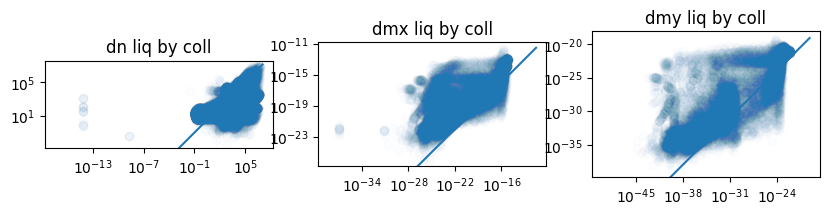

In [62]:
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(1,3)

for i, (yt, yp) in enumerate(zip(y_true_inv, y_pred_inv)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')
    
    plt.scatter(yt, yp, alpha=0.01)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    plt.plot([ax_min, ax_max], [ax_min, ax_max])
    plt.title(var_constraints[i])
    # if i>3:
    plt.xscale('log')
    plt.yscale('log')


In [63]:
fig.savefig('plots/MCMC_multioutput_' + model_name + '.png')

In [64]:
model_name

'multioutput_updraft_coal_4ma_r2'

# save distribution for PPE

In [65]:
samples_raw_vals.shape, case_name

((20000, 8, 10), 'updraft_coal_4ma_r2_N10000_dt300')

In [66]:
nbins = 50
count = {}
bins = {}
sample_sum_chains = samples_origval.reshape(num_samples*nchains,nparam)
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(sample_sum_chains[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

In [67]:
case_name

'updraft_coal_4ma_r2_N10000_dt300'

In [68]:
import netCDF4 as nc
import numpy as np

# Create a new NetCDF file
ncfile = nc.Dataset('MCMC_posterior/' + case_name + '_post.nc', mode='w', format='NETCDF4')

# Create the dimension for parameters and bins
param_dim = ncfile.createDimension('nparam', len(param_names))
binmean_dim = ncfile.createDimension('nbin', nbins)
binedge_dim = ncfile.createDimension('nbinedge', nbins+1)

# Create variables
param_var = ncfile.createVariable('param_names', str, ('nparam',))
density_var = ncfile.createVariable('density', np.float32, ('nparam', 'nbin',))
bin_edges_var = ncfile.createVariable('bin_edges', np.float32, ('nparam', 'nbinedge',))
# sigma_dens_var = ncfile.createVariable('sigma_dens', np.float32, ('nbin',))
# sigma_edge_var = ncfile.createVariable('sigma_edge', np.float32, ('nbinedge',))

# Assign data
param_var[:] = np.array(param_names, dtype='S')
for i, pname in enumerate(param_names):
    # bins[pname] has nbins+1 edges, so we store the left edges for each bin
    density_var[i, :] = count[pname]
    bin_edges_var[i, :] = bins[pname]

# sigma_dens_var[:] = count['sigma'].astype('float32')
# sigma_edge_var[:] = bins['sigma']
ncfile.close()

In [69]:
# pd.DataFrame.from_dict(count).to_csv('MCMC_posterior/' + case_name + '_r0_param_density_narrow.csv', index=False)
# pd.DataFrame.from_dict(bins).to_csv('MCMC_posterior/' + case_name + '_r0_param_bins_narrow.csv', index=False)

In [70]:
model_name

'multioutput_updraft_coal_4ma_r2'

# update params csv

In [71]:
original_params = pd.read_csv(orig_param_csv + '.csv')
updated_params = original_params.copy()
for iparam, param_name in enumerate(param_names):
    binmean = (bins[param_name][1:] + bins[param_name][:-1])/2
    weighted_mean = np.average(binmean, weights=count[param_name])
    weighted_std = np.sqrt(np.cov(binmean, aweights=count[param_name], ddof=0))
    updated_params.loc[0, param_name] = weighted_mean
    updated_params.loc[2, param_name] = weighted_std

# coal_density = pd.read_csv('MCMC_posterior/coal_r2_param_density.csv')
# coal_param_names = coal_density.keys()[1:].to_list()
# coal_bin_edges = pd.read_csv('MCMC_posterior/coal_r2_param_bins.csv')

# for iparam, param_name in enumerate(coal_param_names):
#     binmean = (coal_bin_edges[param_name][1:].to_numpy() + coal_bin_edges[param_name][:-1].to_numpy())/2
#     weighted_mean = np.average(binmean, weights=coal_density[param_name])
#     updated_params.loc[0, param_name] = weighted_mean

updated_params.to_csv(orig_param_csv + '_updated_coal_4ma_r2.csv', index=False)

In [72]:
# np.std(binmean, weights=count[param_name])
updated_params

,Unnamed: 0,a0evap1_db,a0evap2_db,bm0evap1,bm0evap2,bx0evap1,bx0evap2,by0evap1,by0evap2,aevap_db,...,afall_db,bmfall,bx0fall,bx3fall,bxxfall,bxyfall,by0fall,by3fall,byxfall,byyfall
0,mean,38.610585,3.687102,-0.000563,-1.909830,1.576014,1.903903,-1.072642,-0.066690,-67.006062,...,-6.675757,0.571666,-0.146511,0.453007,0.038145,0.463250,0.451673,0.383639,-0.126374,0.775577
1,sd,0.190511,0.491666,0.000563,0.018053,0.027335,0.022666,0.036891,0.030800,0.013542,...,0.021235,0.001045,0.001771,0.002443,0.002072,0.002860,0.002301,0.005232,0.003649,0.005056
2,isd,32.997431,85.159046,0.097588,3.126787,4.734566,3.925938,6.389758,5.334682,2.345544,...,2.123531,0.104500,0.177060,0.244264,0.207151,0.285998,0.230120,0.523239,0.364868,0.505613
